<a href="https://colab.research.google.com/github/MassielC/pythonML_portfolio/blob/main/project01_feature_selection_AD_DARWIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Selection for Alzheimer’s Diagnosis Using the DARWIN Handwriting Dataset
---

## **Introduction**

### **Objective**  
The objective of this project is to use feature selection methods to identify the most representative handwriting features for predicting Alzheimer’s Disease (AD) using the DARWIN dataset. This approach aims to address the challenges of high dimensionality and overfitting while enhancing model performance.

---

### **Context**  
The DARWIN dataset is a novel and comprehensive resource for handwriting-based AD prediction. It is the largest publicly available dataset of its kind, containing data from **174 participants** (89 AD patients and 85 healthy controls) across **25 handwriting tasks**. Each participant is represented by **450 features**, derived from tasks designed to evaluate cognitive function.  

This dataset addresses key limitations of prior studies, such as the lack of publicly available data, by enabling:  
1. Fair performance comparisons of methodologies for AD prediction via handwriting analysis.  
2. A robust foundation for future tools and techniques in cognitive impairment diagnosis.

This project builds on the work of Cilia et al. (2018), who demonstrated the effectiveness of this dataset for AD diagnosis using widely known classifiers.  

**Reference**:  
N. D. Cilia, C. De Stefano, F. Fontanella, A. S. Di Freca, *An experimental protocol to support cognitive impairment diagnosis by using handwriting analysis*, Procedia Computer Science 141 (2018) 466–471. https://doi.org/10.1016/j.procs.2018.10.141  

---

### **Dataset**  
- **Participants**: 174 (89 AD patients, 85 healthy controls).  
- **Tasks**: 25 handwriting tasks across four categories.  
- **Features**: 450 features per participant, capturing a wide range of handwriting dynamics.

---

### **Problem Statement**  
The high dimensionality of the dataset introduces challenges such as overfitting and computational inefficiency. This project explores feature selection methods to:  
1. Reduce the dimensionality while retaining diagnostic accuracy.  
2. Identify the most informative handwriting features for distinguishing AD patients from healthy individuals.

## **Methodology**

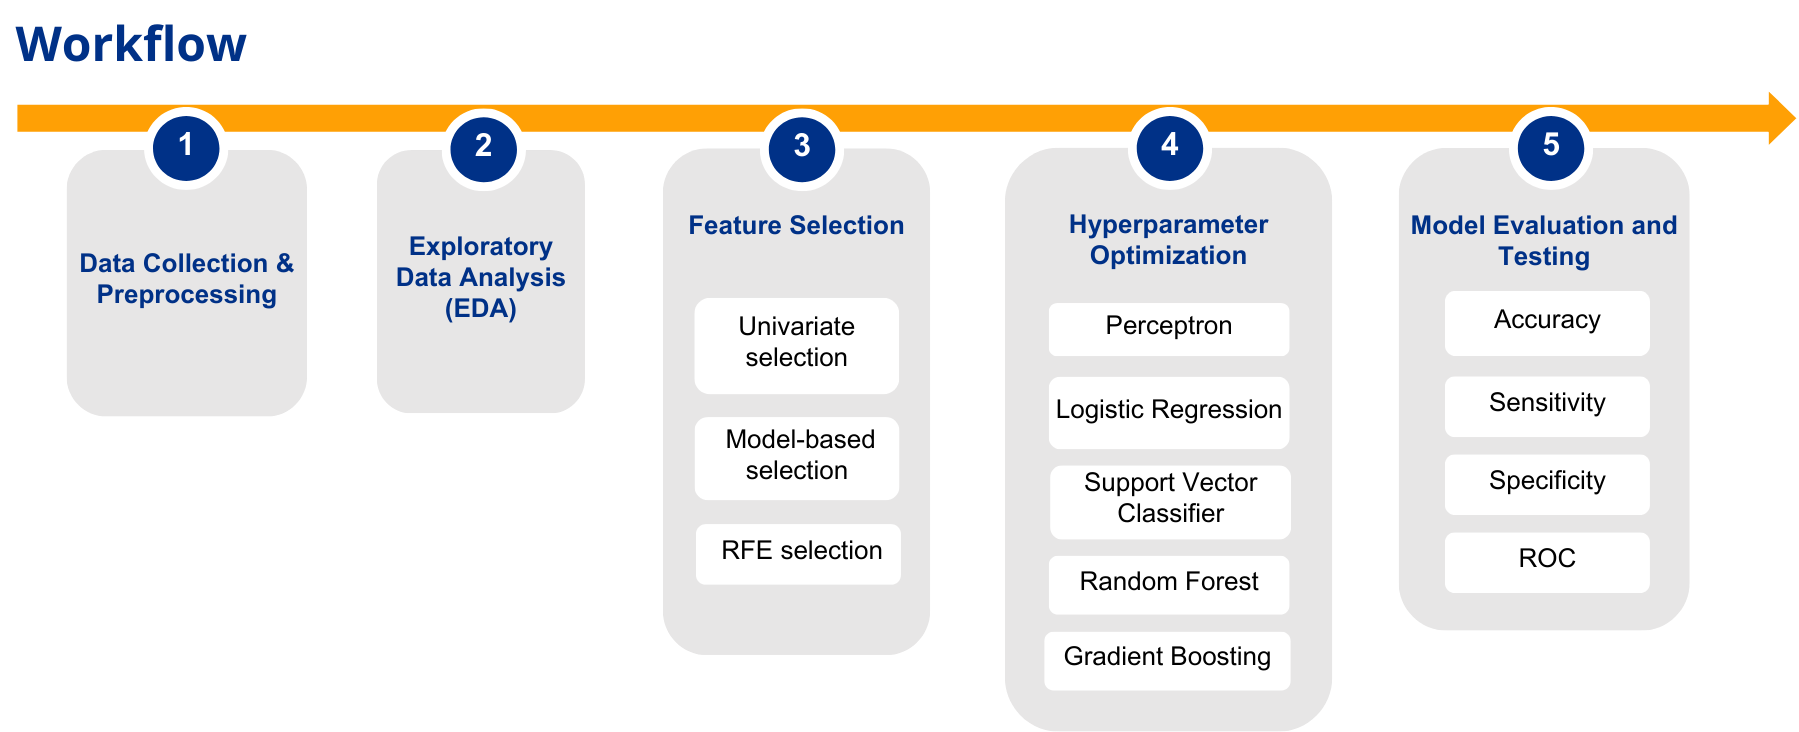

In [ ]:
!pip install -q ucimlrepo

## Import dataset

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
darwin = fetch_ucirepo(id=732)

# data (as pandas dataframes)
X = darwin.data.features
X = X.drop(X.columns[0], axis=1)
y = darwin.data.targets
y = y.replace('H', 0)
y = y.replace('P', 1)
# metadata: print(darwin.metadata)
# variable information: print(darwin.variables)

print(X.shape)
print(y.shape)

(174, 450)
(174, 1)


<ipython-input-4-c6098ba629f0>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace('P', 1)


**Key observation:** High dimensionality

## Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Exploratory Data Analysis (EDA)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for ex

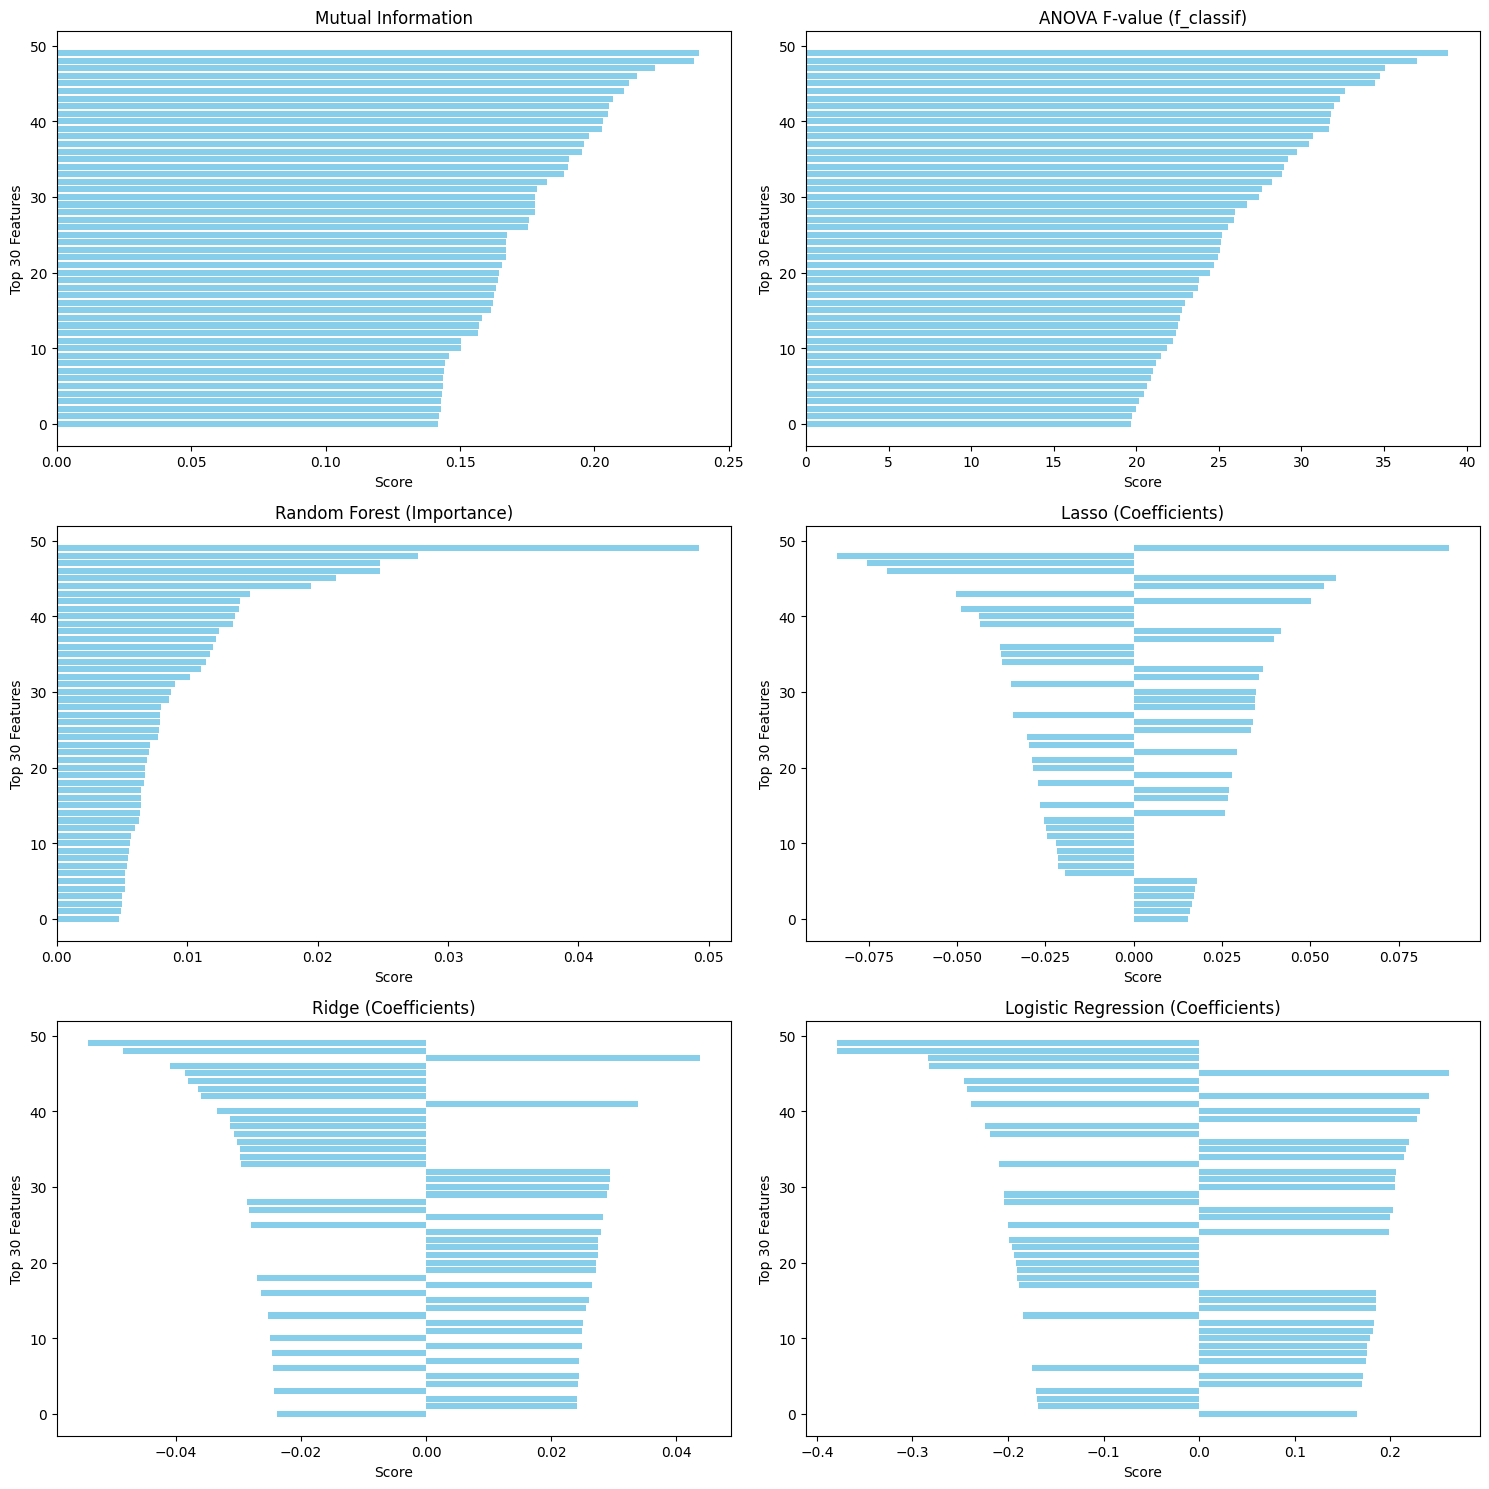

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler

# Standardize for coefficient-based models
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Define feature selection methods
methods = {
    "Mutual Information": lambda X, y: mutual_info_classif(X, y, random_state=42),
    "ANOVA F-value (f_classif)": lambda X, y: f_classif(X, y)[0],
    "Random Forest (Importance)": RandomForestClassifier(random_state=42).fit(X_train, y_train).feature_importances_,
    "Lasso (Coefficients)": Lasso(alpha=0.01, random_state=42, max_iter=1000).fit(X_train_scaled, y_train).coef_,
    "Ridge (Coefficients)": Ridge(alpha=10, random_state=42, max_iter=1000).fit(X_train_scaled, y_train).coef_.flatten(),
    "Logistic Regression (Coefficients)": LogisticRegression(penalty='l2', max_iter=1000, random_state=42).fit(X_train_scaled, y_train).coef_[0],
}

plt.figure(figsize=(15, 15))

for i, (name, method) in enumerate(methods.items(), 1):
    # Calculate feature scores
    if callable(method):
        scores = method(X_train, y_train)
    else:
        scores = method

    # Ensure scores are a numpy array and validate dimensions
    scores = np.array(scores)
    if len(scores) != X_train.shape[1]:
        print(f"Warning: Mismatch in scores length for {name}. Skipping.")
        continue

    # Sort scores
    sorted_indices = np.argsort(np.abs(scores))[::-1]
    sorted_scores = scores[sorted_indices]

    # Plot sorted scores without feature names
    plt.subplot(3, 2, i)
    plt.barh(range(len(sorted_scores[:50])), sorted_scores[:50][::-1], color='skyblue')
    plt.title(name)
    plt.xlabel("Score")
    plt.ylabel("Top 30 Features")
    plt.tight_layout()

plt.show()



# **FEATURE SELECTION**
---------------

## Functions definition

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

def select_features(X_train, y_train, feature_selector, standardize=False):
    """
    Perform feature selection on the training data.

    Args:
        X_train (pd.DataFrame): Training feature set.
        y_train (pd.Series): Training target.
        feature_selector (sklearn selector): Feature selection method.
        standardize (bool): Whether to standardize the features before selection.

    Returns:
        list: Selected feature names.
    """
    # Optionally standardize the features
    if standardize:
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    # Apply feature selection
    feature_selector.fit(X_train, y_train)
    selected_features = feature_selector.get_support()
    feature_names = X_train.columns[selected_features]

    # Handle coef_ for models like Ridge, Lasso (via estimator_ inside SelectFromModel)
    if hasattr(feature_selector, 'estimator_') and hasattr(feature_selector.estimator_, 'coef_'):
        # Use coef_ for models like Ridge and Lasso
        coefficients = feature_selector.estimator_.coef_.flatten()  # Flatten for consistency
        ranked_features = sorted(
            zip(feature_names, coefficients[selected_features]),
            key=lambda x: abs(x[1]),  # Sort by absolute value of coefficients
            reverse=True
        )
        print("\nSelected Features and Coefficients:")
        for name, coef in ranked_features:
            print(f"{name}: {coef:.4f}")

    # Handle feature_importances_ for tree-based models (e.g., RandomForest)
    elif hasattr(feature_selector, 'estimator_') and hasattr(feature_selector.estimator_, 'feature_importances_'):
        importances = feature_selector.estimator_.feature_importances_
        ranked_features = sorted(
            zip(feature_names, importances[selected_features]),
            key=lambda x: x[1],
            reverse=True
        )
        print("\nSelected Features and Importances:")
        for name, importance in ranked_features:
            print(f"{name}: {importance:.4f}")

    # Handle scores_ for other selectors (e.g., SelectKBest with f_classif)
    elif hasattr(feature_selector, 'scores_'):
        feature_scores = feature_selector.scores_
        ranked_features = sorted(
            zip(feature_names, feature_scores[selected_features]),
            key=lambda x: x[1],
            reverse=True
        )
        print("\nSelected Features and Scores:")
        for name, score in ranked_features:
            print(f"{name}: {score:.4f}")

    else:
        print("\nSelected Features (no scores or coefficients available):")
        for name in feature_names:
            print(name)

    return feature_names



In [ ]:
def tune_hyperparameters(X_train, y_train, model_params, selected_features):
    results = {}
    models_that_need_scaling = ['Logistic Regression', 'SVM', 'Perceptron']
    metrics_summary = []

    for model_name, (model, param_grid) in model_params.items():
        print(f"\nTuning {model_name}...")

        # Standardization
        if model_name in models_that_need_scaling:
            scaler = StandardScaler()
            X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        else:
            X_train_scaled = X_train

        scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

        grid_search = GridSearchCV(
            estimator=clone(model),
            param_grid=param_grid,
            cv=3,
            scoring=scoring,
            refit='roc_auc',
            n_jobs=-1
        )

        X_train_selected = X_train_scaled.loc[:, selected_features]
        grid_search.fit(X_train_selected, y_train)

        best_accuracy = grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]
        best_auc = grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_]

        print(f"Best {model_name} Parameters: {grid_search.best_params_}")
        print(f"Best {model_name} AUC Score: {best_auc:.3f}")
        print(f"Best {model_name} Accuracy: {best_accuracy:.3f}")

        results[model_name] = {
            'best_model': grid_search.best_estimator_,
            'selected_features': selected_features,
            'train_accuracy': best_accuracy,
            'best_auc': best_auc
        }

        metrics_summary.append({
            'Model': model_name,
            'train_accuracy': best_accuracy
        })

    train_metrics_df = pd.DataFrame(metrics_summary)
    return results, train_metrics_df


def evaluate_test_set(X_train, X_test, y_test, best_models):
    print("\nEvaluation Results on Test Set:")
    metrics = []

    scaler = StandardScaler()
    for model_name, model_info in best_models.items():
        print(f"\nEvaluating {model_name}...")

        model = model_info['best_model']
        selected_features = model_info['selected_features']
        X_test_selected = X_test.loc[:, selected_features]

        if model_name in ['Logistic Regression', 'SVM', 'Perceptron']:
            X_train_selected = X_train.loc[:, selected_features]
            X_train_scaled = scaler.fit_transform(X_train_selected)
            X_test_scaled = scaler.transform(X_test_selected)
            X_test_selected = X_test_scaled

        if hasattr(model, 'predict_proba'):
            y_probs = model.predict_proba(X_test_selected)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_probs = model.decision_function(X_test_selected)
        else:
            y_probs = model.predict(X_test_selected)

        y_preds = (y_probs >= 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_preds)
        sensitivity = recall_score(y_test, y_preds)
        tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
        specificity = tn / (tn + fp)
        auc = roc_auc_score(y_test, y_probs)

        print(f"Accuracy: {accuracy:.3f}")
        print(f"Sensitivity: {sensitivity:.3f}")
        print(f"Specificity: {specificity:.3f}")
        print(f"AUC: {auc:.4f}")

        metrics.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'AUC': auc
        })
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')

    # Finalize ROC curve plot
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.title("ROC Curves for All Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    test_metrics_df = pd.DataFrame(metrics)
    return test_metrics_df

## Models definition

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score, roc_curve
from sklearn.base import clone
import matplotlib.pyplot as plt

# Define model parameters
model_parameters = {
    'Logistic Regression': (LogisticRegression(max_iter=1000,random_state=8), {
        'C': np.logspace(-3, 3, 7),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }),
    'Random Forest': (RandomForestClassifier(random_state=8), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=8), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 7]
    }),
    'SVM': (SVC(probability=True), {
        'C': np.logspace(-3, 3, 7),
        'gamma': ['scale', 'auto', 0.1, 1, 10],
        'kernel': ['linear']
    }),
    'Perceptron': (Perceptron(max_iter=1000,random_state=8), {
        'eta0': np.logspace(-4, 0, 5),
        'penalty': ['l1', 'l2', None]
    })

}

## SelectKbest (Univariate selection)

### ANOVA (f-classif)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Selected Features and Scores:
disp_index23: 38.8679
total_time2: 36.9896
gmrt_in_air7: 35.0490
total_time3: 34.7266
air_time16: 34.4504
paper_time17: 32.6351
total_time13: 32.3295
paper_time9: 31.9426
paper_time23: 31.8069
mean_speed_in_air7: 31.7450
air_time2: 31.6626
total_time16: 30.6756
disp_index22: 30.4751
mean_gmrt7: 29.7392
mean_gmrt17: 29.2087
air_time22: 28.9233
total_time22: 28.8151
pressure_var5: 28.2312
total_time9: 27.5904
pressure_mean8: 27.4366

Tuning Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Logistic Regression AUC Score: 0.940
Best Logistic Regression Accuracy: 0.849

Tuning Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest AUC Score: 0.948
Best Random Forest Accuracy: 0.863

Tuning Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Gradient Boosting AUC Score: 0.910
Best Gradient Boosting Accuracy: 0.827

Tuning SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best SVM Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM AUC Score: 0.943
Best SVM Accuracy: 0.863

Tuning Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(


Best Perceptron Parameters: {'eta0': 0.01, 'penalty': 'l1'}
Best Perceptron AUC Score: 0.909
Best Perceptron Accuracy: 0.806

Evaluation Results on Test Set:

Evaluating Logistic Regression...
Accuracy: 0.829
Sensitivity: 0.810
Specificity: 0.857
AUC: 0.9422

Evaluating Random Forest...
Accuracy: 0.943
Sensitivity: 0.905
Specificity: 1.000
AUC: 0.9626

Evaluating Gradient Boosting...
Accuracy: 0.886
Sensitivity: 0.810
Specificity: 1.000
AUC: 0.9626

Evaluating SVM...
Accuracy: 0.829
Sensitivity: 0.810
Specificity: 0.857
AUC: 0.9422

Evaluating Perceptron...
Accuracy: 0.429
Sensitivity: 0.048
Specificity: 1.000
AUC: 0.9354


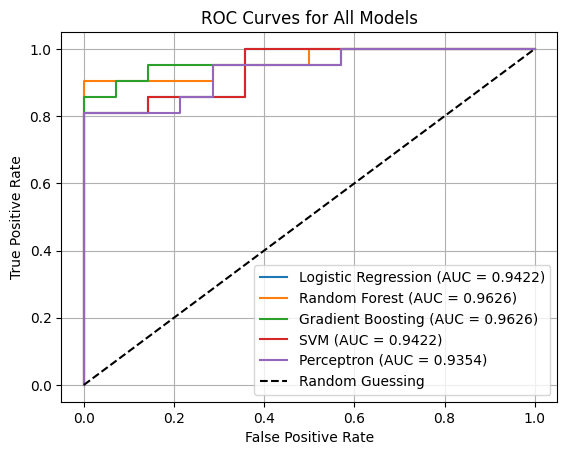


Final Model Performance Summary:


,Model,train_accuracy,Accuracy,Sensitivity,Specificity,AUC
0,Logistic Regression,0.848905,0.828571,0.809524,0.857143,0.942177
1,Random Forest,0.863090,0.942857,0.904762,1.000000,0.962585
2,Gradient Boosting,0.827166,0.885714,0.809524,1.000000,0.962585
3,SVM,0.863090,0.828571,0.809524,0.857143,0.942177
4,Perceptron,0.806044,0.428571,0.047619,1.000000,0.935374


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif


# Define feature selector
selector = SelectKBest(score_func=f_classif, k=20)

# Feature selection
selected_features = select_features(X_train, y_train, selector, standardize=True)

# Combine Results
train_results, train_metrics_df = tune_hyperparameters(X_train, y_train, model_parameters, selected_features)
test_metrics_df = evaluate_test_set(X_train, X_test, y_test, train_results)

# Merge Tables
final_summary_df = pd.merge(train_metrics_df, test_metrics_df, on='Model')
print("\nFinal Model Performance Summary:")
final_summary_df

### Mutual information

**`k=20` (Best result)**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Selected Features and Scores:
total_time10: 0.2394
total_time17: 0.2378
total_time25: 0.2226
num_of_pendown5: 0.2185
total_time15: 0.2160
paper_time23: 0.2142
num_of_pendown19: 0.2127
paper_time11: 0.2106
total_time9: 0.2073
air_time23: 0.2070
pressure_mean19: 0.2051
air_time22: 0.2036
total_time23: 0.1960
total_time22: 0.1959
max_x_extension19: 0.1950
air_time20: 0.1928
air_time11: 0.1917
pressure_var19: 0.1887
paper_time17: 0.1866
mean_speed_on_paper10: 0.1785

Tuning Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Logistic Regression Parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression AUC Score: 0.951
Best Logistic Regression Accuracy: 0.870

Tuning Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest AUC Score: 0.973
Best Random Forest Accuracy: 0.899

Tuning Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Gradient Boosting Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
Best Gradient Boosting AUC Score: 0.971
Best Gradient Boosting Accuracy: 0.877

Tuning SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best SVM Parameters: {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM AUC Score: 0.938
Best SVM Accuracy: 0.518

Tuning Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Best Perceptron Parameters: {'eta0': 0.01, 'penalty': 'l1'}
Best Perceptron AUC Score: 0.907
Best Perceptron Accuracy: 0.856

Evaluation Results on Test Set:

Evaluating Logistic Regression...
Accuracy: 0.857
Sensitivity: 0.857
Specificity: 0.857
AUC: 0.8724

Evaluating Random Forest...
Accuracy: 0.914
Sensitivity: 0.905
Specificity: 0.929
AUC: 0.9558

Evaluating Gradient Boosting...
Accuracy: 0.943
Sensitivity: 0.952
Specificity: 0.929
AUC: 0.9932

Evaluating SVM...
Accuracy: 0.857
Sensitivity: 0.857
Specificity: 0.857
AUC: 0.8793

Evaluating Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(


Accuracy: 0.514
Sensitivity: 0.238
Specificity: 0.929
AUC: 0.8537


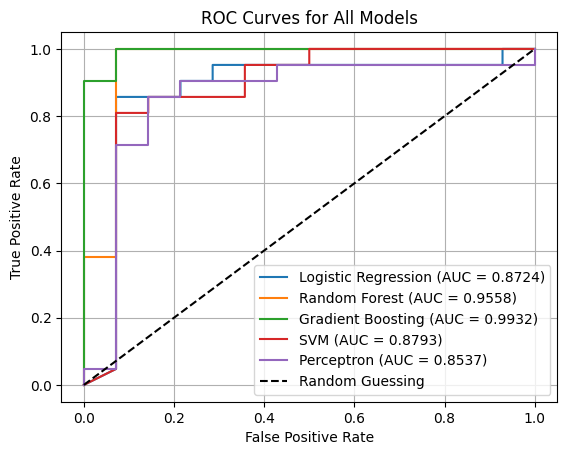


Final Model Performance Summary:


,Model,train_accuracy,Accuracy,Sensitivity,Specificity,AUC
0,Logistic Regression,0.870182,0.857143,0.857143,0.857143,0.872449
1,Random Forest,0.899322,0.914286,0.904762,0.928571,0.955782
2,Gradient Boosting,0.877428,0.942857,0.952381,0.928571,0.993197
3,SVM,0.517885,0.857143,0.857143,0.857143,0.879252
4,Perceptron,0.855998,0.514286,0.238095,0.928571,0.853741


In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Define feature selector using mutual information
selector_mutual_info = SelectKBest(score_func=mutual_info_classif, k=20)

# Feature selection using mutual information
selected_features_mutual_info = select_features(X_train, y_train, selector_mutual_info, standardize=False)

# Combine Results
train_results, train_metrics_df = tune_hyperparameters(X_train, y_train, model_parameters, selected_features_mutual_info)
test_metrics_df = evaluate_test_set(X_train, X_test, y_test, train_results)

# Merge Tables
final_summary_df = pd.merge(train_metrics_df, test_metrics_df, on='Model')
print("\nFinal Model Performance Summary:")
final_summary_df

**`k=30 (Not better than 20)`**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Selected Features and Scores:
total_time10: 0.2394
total_time17: 0.2372
total_time25: 0.2226
total_time15: 0.2160
num_of_pendown19: 0.2150
paper_time11: 0.2130
paper_time23: 0.2087
air_time23: 0.2083
pressure_mean19: 0.2051
air_time22: 0.2043
total_time9: 0.2016
max_x_extension19: 0.1974
total_time22: 0.1959
total_time23: 0.1942
air_time20: 0.1938
pressure_var19: 0.1887
air_time11: 0.1866
paper_time17: 0.1849
mean_speed_on_paper10: 0.1785
max_y_extension19: 0.1762
paper_time19: 0.1762
pressure_mean8: 0.1757
mean_speed_on_paper8: 0.1752
total_time13: 0.1749
air_time16: 0.1686
mean_speed_on_paper19: 0.1675
total_time19: 0.1672
mean_acc_in_air17: 0.1671
air_time19: 0.1670
paper_time12: 0.1646

Tuning Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Best Logistic Regression AUC Score: 0.965
Best Logistic Regression Accuracy: 0.863

Tuning Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest AUC Score: 0.975
Best Random Forest Accuracy: 0.899

Tuning Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Gradient Boosting AUC Score: 0.957
Best Gradient Boosting Accuracy: 0.870

Tuning SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best SVM Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM AUC Score: 0.966
Best SVM Accuracy: 0.848

Tuning Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Best Perceptron Parameters: {'eta0': 0.0001, 'penalty': 'l1'}
Best Perceptron AUC Score: 0.930
Best Perceptron Accuracy: 0.870

Evaluation Results on Test Set:

Evaluating Logistic Regression...
Accuracy: 0.829
Sensitivity: 0.762
Specificity: 0.929
AUC: 0.9048

Evaluating Random Forest...
Accuracy: 0.914
Sensitivity: 0.905
Specificity: 0.929
AUC: 0.9745

Evaluating Gradient Boosting...
Accuracy: 0.886
Sensitivity: 0.857
Specificity: 0.929
AUC: 0.9898

Evaluating SVM...
Accuracy: 0.829
Sensitivity: 0.810
Specificity: 0.857
AUC: 0.8963

Evaluating Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(


Accuracy: 0.400
Sensitivity: 0.000
Specificity: 1.000
AUC: 0.9048


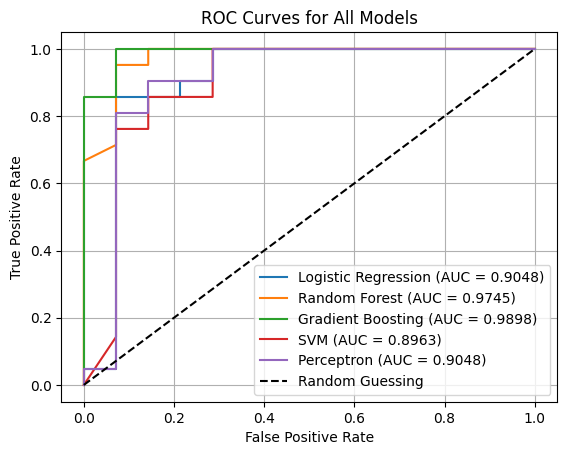


Final Model Performance Summary:


,Model,train_accuracy,Accuracy,Sensitivity,Specificity,AUC
0,Logistic Regression,0.862627,0.828571,0.761905,0.928571,0.904762
1,Random Forest,0.899322,0.914286,0.904762,0.928571,0.974490
2,Gradient Boosting,0.870182,0.885714,0.857143,0.928571,0.989796
3,SVM,0.848443,0.828571,0.809524,0.857143,0.896259
4,Perceptron,0.869719,0.400000,0.000000,1.000000,0.904762


In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Define feature selector using mutual information
selector_mutual_info = SelectKBest(score_func=mutual_info_classif, k=30)

# Feature selection using mutual information
selected_features_mutual_info = select_features(X_train, y_train, selector_mutual_info, standardize=False)

# Combine Results
train_results, train_metrics_df = tune_hyperparameters(X_train, y_train, model_parameters, selected_features_mutual_info)
test_metrics_df = evaluate_test_set(X_train, X_test, y_test, train_results)

# Merge Tables
final_summary_df = pd.merge(train_metrics_df, test_metrics_df, on='Model')
print("\nFinal Model Performance Summary:")
final_summary_df

**`k=15` (Not better than 20)**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Selected Features and Scores:
total_time17: 0.2378
total_time10: 0.2370
total_time25: 0.2226
num_of_pendown19: 0.2215
total_time15: 0.2160
air_time23: 0.2075
paper_time11: 0.2063
pressure_mean19: 0.2051
air_time22: 0.2049
total_time9: 0.2036
paper_time23: 0.2021
max_x_extension19: 0.1980
total_time22: 0.1952
total_time23: 0.1942
air_time20: 0.1914

Tuning Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Logistic Regression Parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}
Best Logistic Regression AUC Score: 0.937
Best Logistic Regression Accuracy: 0.849

Tuning Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest AUC Score: 0.969
Best Random Forest Accuracy: 0.878

Tuning Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Gradient Boosting Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
Best Gradient Boosting AUC Score: 0.969
Best Gradient Boosting Accuracy: 0.870

Tuning SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best SVM Parameters: {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM AUC Score: 0.936
Best SVM Accuracy: 0.511

Tuning Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(


Best Perceptron Parameters: {'eta0': 0.01, 'penalty': 'l1'}
Best Perceptron AUC Score: 0.900
Best Perceptron Accuracy: 0.842

Evaluation Results on Test Set:

Evaluating Logistic Regression...
Accuracy: 0.914
Sensitivity: 0.857
Specificity: 1.000
AUC: 0.9354

Evaluating Random Forest...
Accuracy: 0.914
Sensitivity: 0.905
Specificity: 0.929
AUC: 0.9898

Evaluating Gradient Boosting...
Accuracy: 0.914
Sensitivity: 0.905
Specificity: 0.929
AUC: 0.9898

Evaluating SVM...
Accuracy: 0.714
Sensitivity: 0.524
Specificity: 1.000
AUC: 0.9524

Evaluating Perceptron...
Accuracy: 0.543
Sensitivity: 0.238
Specificity: 1.000
AUC: 0.9082


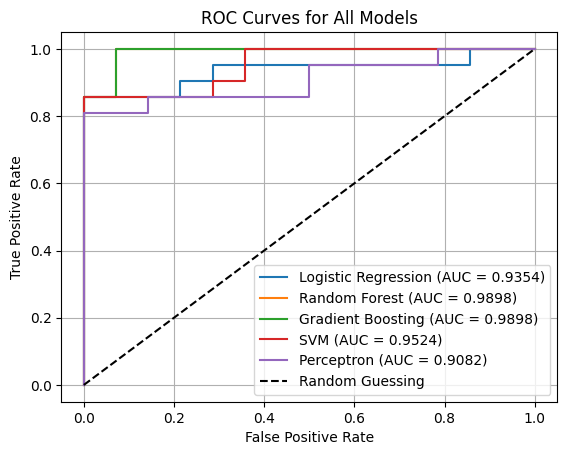


Final Model Performance Summary:


,Model,train_accuracy,Accuracy,Sensitivity,Specificity,AUC
0,Logistic Regression,0.848751,0.914286,0.857143,1.000000,0.935374
1,Random Forest,0.877737,0.914286,0.904762,0.928571,0.989796
2,Gradient Boosting,0.870490,0.914286,0.904762,0.928571,0.989796
3,SVM,0.510792,0.714286,0.523810,1.000000,0.952381
4,Perceptron,0.841813,0.542857,0.238095,1.000000,0.908163


In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Define feature selector using mutual information
selector_mutual_info = SelectKBest(score_func=mutual_info_classif, k=15)

# Feature selection using mutual information
selected_features_mutual_info = select_features(X_train, y_train, selector_mutual_info, standardize=False)

# Combine Results
train_results, train_metrics_df = tune_hyperparameters(X_train, y_train, model_parameters, selected_features_mutual_info)
test_metrics_df = evaluate_test_set(X_train, X_test, y_test, train_results)

# Merge Tables
final_summary_df = pd.merge(train_metrics_df, test_metrics_df, on='Model')
print("\nFinal Model Performance Summary:")
final_summary_df

## SelectFromModel (Model-based selection)

### Random Forest selection

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Selected Features and Importances:
total_time23: 0.0334
air_time17: 0.0251
air_time5: 0.0248
total_time17: 0.0245
pressure_var19: 0.0171
air_time16: 0.0169
paper_time17: 0.0154
total_time9: 0.0145
air_time15: 0.0142
air_time23: 0.0133
total_time2: 0.0129
pressure_mean5: 0.0124
total_time16: 0.0120
total_time6: 0.0117
pressure_var5: 0.0115
num_of_pendown19: 0.0113
disp_index23: 0.0104
gmrt_in_air17: 0.0103
pressure_mean8: 0.0103
air_time6: 0.0100
total_time12: 0.0100
air_time7: 0.0097
air_time13: 0.0097
pressure_mean19: 0.0094
paper_time9: 0.0094
pressure_mean4: 0.0092
total_time7: 0.0089
paper_time10: 0.0089
paper_time8: 0.0086
paper_time22: 0.0084
total_time22: 0.0084
mean_gmrt8: 0.0082
gmrt_on_paper8: 0.0079
pressure_mean9: 0.0078
max_x_extension21: 0.0077
disp_index22: 0.0069
paper_time23: 0.0068
disp_index20: 0.0067
gmrt_on_paper10: 0.0067
mean_jerk_in_air17: 0.0065
mean_acc_in_air17: 0.0065
max_y_extension9: 0.0064
paper_time6: 0.0063
pressure_var4: 0.0063
paper_time20: 0.0061
pr

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Logistic Regression Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best Logistic Regression AUC Score: 0.966
Best Logistic Regression Accuracy: 0.899

Tuning Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Random Forest AUC Score: 0.982
Best Random Forest Accuracy: 0.907

Tuning Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Gradient Boosting Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50}
Best Gradient Boosting AUC Score: 0.966
Best Gradient Boosting Accuracy: 0.848

Tuning SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best SVM Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM AUC Score: 0.970
Best SVM Accuracy: 0.892

Tuning Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(


Best Perceptron Parameters: {'eta0': 1.0, 'penalty': 'l2'}
Best Perceptron AUC Score: 0.921
Best Perceptron Accuracy: 0.864

Evaluation Results on Test Set:

Evaluating Logistic Regression...
Accuracy: 0.886
Sensitivity: 0.857
Specificity: 0.929
AUC: 0.9014

Evaluating Random Forest...
Accuracy: 0.914
Sensitivity: 0.952
Specificity: 0.857
AUC: 0.9864

Evaluating Gradient Boosting...
Accuracy: 0.943
Sensitivity: 0.952
Specificity: 0.929
AUC: 0.9932

Evaluating SVM...
Accuracy: 0.886
Sensitivity: 0.905
Specificity: 0.857
AUC: 0.9048

Evaluating Perceptron...
Accuracy: 0.829
Sensitivity: 0.857
Specificity: 0.786
AUC: 0.8571


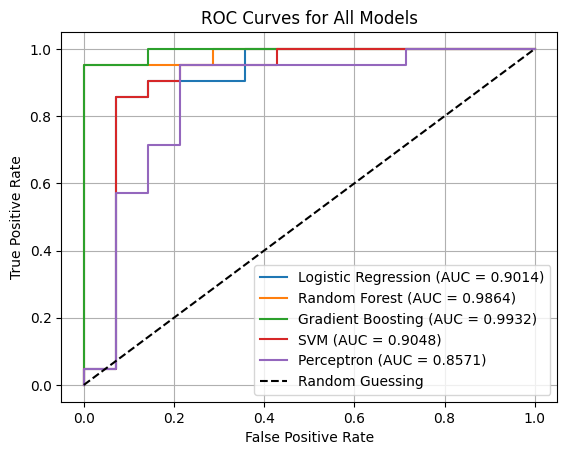


Final Model Performance Summary:


,Model,train_accuracy,Accuracy,Sensitivity,Specificity,AUC
0,Logistic Regression,0.899167,0.885714,0.857143,0.928571,0.901361
1,Random Forest,0.906568,0.914286,0.952381,0.857143,0.986395
2,Gradient Boosting,0.848443,0.942857,0.952381,0.928571,0.993197
3,SVM,0.892075,0.885714,0.904762,0.857143,0.904762
4,Perceptron,0.863861,0.828571,0.857143,0.785714,0.857143


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
# Define RandomForest model for feature selection
rf = RandomForestClassifier(n_estimators=100,random_state=8)

# Define feature selector using SelectFromModel with RandomForest
# max_features=20????
selector = SelectFromModel(rf, threshold="mean")

# Feature selection
selected_features = select_features(X_train, y_train, selector, standardize=False)

# Hyperparameter tuning

# Combine Results
train_results, train_metrics_df = tune_hyperparameters(X_train, y_train, model_parameters, selected_features)
test_metrics_df = evaluate_test_set(X_train, X_test, y_test, train_results)

# Merge Tables
final_summary_df = pd.merge(train_metrics_df, test_metrics_df, on='Model')
print("\nFinal Model Performance Summary:")
final_summary_df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Selected Features and Importances:
total_time23: 0.0334
air_time17: 0.0251
air_time5: 0.0248
total_time17: 0.0245
pressure_var19: 0.0171
air_time16: 0.0169
paper_time17: 0.0154
total_time9: 0.0145
air_time15: 0.0142
air_time23: 0.0133
total_time2: 0.0129
pressure_mean5: 0.0124
total_time16: 0.0120
total_time6: 0.0117
pressure_var5: 0.0115
num_of_pendown19: 0.0113
disp_index23: 0.0104
gmrt_in_air17: 0.0103
pressure_mean8: 0.0103
air_time6: 0.0100

Tuning Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Logistic Regression AUC Score: 0.957
Best Logistic Regression Accuracy: 0.856

Tuning Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Random Forest AUC Score: 0.974
Best Random Forest Accuracy: 0.907

Tuning Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Gradient Boosting Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
Best Gradient Boosting AUC Score: 0.967
Best Gradient Boosting Accuracy: 0.878

Tuning SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best SVM Parameters: {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM AUC Score: 0.955
Best SVM Accuracy: 0.554

Tuning Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(


Best Perceptron Parameters: {'eta0': 0.0001, 'penalty': 'l1'}
Best Perceptron AUC Score: 0.933
Best Perceptron Accuracy: 0.849

Evaluation Results on Test Set:

Evaluating Logistic Regression...
Accuracy: 0.886
Sensitivity: 0.810
Specificity: 1.000
AUC: 0.9728

Evaluating Random Forest...
Accuracy: 0.886
Sensitivity: 1.000
Specificity: 0.714
AUC: 0.9694

Evaluating Gradient Boosting...
Accuracy: 0.914
Sensitivity: 0.952
Specificity: 0.857
AUC: 0.9864

Evaluating SVM...
Accuracy: 0.886
Sensitivity: 0.810
Specificity: 1.000
AUC: 0.9694

Evaluating Perceptron...
Accuracy: 0.400
Sensitivity: 0.000
Specificity: 1.000
AUC: 0.9796


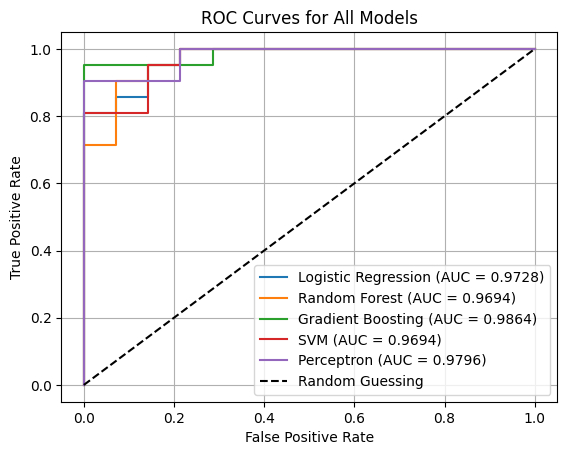


Final RF with 20 features, Performance Summary:


,Model,train_accuracy,Accuracy,Sensitivity,Specificity,AUC
0,Logistic Regression,0.856152,0.885714,0.809524,1.000000,0.972789
1,Random Forest,0.906722,0.885714,1.000000,0.714286,0.969388
2,Gradient Boosting,0.877891,0.914286,0.952381,0.857143,0.986395
3,SVM,0.554117,0.885714,0.809524,1.000000,0.969388
4,Perceptron,0.849214,0.400000,0.000000,1.000000,0.979592


In [ ]:
# Define RandomForest model for feature selection
rf = RandomForestClassifier(n_estimators=100,random_state=8)

# Define feature selector using SelectFromModel with RandomForest
# max_features=20 DIFFERENCE HERE!!!!!!
selector = SelectFromModel(rf, threshold="mean",max_features=20)

# Feature selection
selected_features = select_features(X_train, y_train, selector, standardize=False)

# Hyperparameter tuning

# Combine Results
train_results, train_metrics_df = tune_hyperparameters(X_train, y_train, model_parameters, selected_features)
test_metrics_df = evaluate_test_set(X_train, X_test, y_test, train_results)

# Merge Tables
final_summary_df = pd.merge(train_metrics_df, test_metrics_df, on='Model')
print("\nFinal RF with 20 features, Performance Summary:")
final_summary_df

### Lasso Selection


Selected Features and Coefficients:
air_time22: 0.0894
num_of_pendown19: -0.0841
pressure_mean2: -0.0753
pressure_var19: -0.0697
mean_jerk_in_air22: 0.0572
gmrt_on_paper6: 0.0538
mean_speed_on_paper8: -0.0504
max_x_extension4: 0.0503
gmrt_on_paper2: -0.0488
mean_jerk_in_air10: -0.0438
mean_acc_on_paper16: -0.0436
mean_jerk_in_air2: 0.0417
mean_acc_in_air13: 0.0396
mean_acc_on_paper12: -0.0377
disp_index4: -0.0374
mean_speed_in_air23: -0.0371
air_time25: 0.0366
max_x_extension25: 0.0355
disp_index21: -0.0347
total_time17: 0.0346

Tuning Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Logistic Regression Parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Logistic Regression AUC Score: 0.967
Best Logistic Regression Accuracy: 0.928

Tuning Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest AUC Score: 0.972
Best Random Forest Accuracy: 0.921

Tuning Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Gradient Boosting AUC Score: 0.961
Best Gradient Boosting Accuracy: 0.849

Tuning SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best SVM Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM AUC Score: 0.966
Best SVM Accuracy: 0.885

Tuning Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(


Best Perceptron Parameters: {'eta0': 0.1, 'penalty': None}
Best Perceptron AUC Score: 0.952
Best Perceptron Accuracy: 0.892

Evaluation Results on Test Set:

Evaluating Logistic Regression...
Accuracy: 0.771
Sensitivity: 0.762
Specificity: 0.786
AUC: 0.8163

Evaluating Random Forest...
Accuracy: 0.914
Sensitivity: 0.905
Specificity: 0.929
AUC: 0.9677

Evaluating Gradient Boosting...
Accuracy: 0.886
Sensitivity: 0.905
Specificity: 0.857
AUC: 0.9762

Evaluating SVM...
Accuracy: 0.800
Sensitivity: 0.762
Specificity: 0.857
AUC: 0.8537

Evaluating Perceptron...
Accuracy: 0.743
Sensitivity: 0.667
Specificity: 0.857
AUC: 0.8503


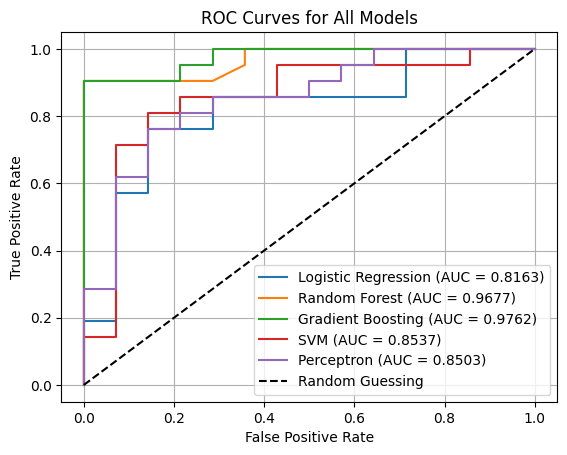


Final RF with 25 features, Performance Summary:


,Model,train_accuracy,Accuracy,Sensitivity,Specificity,AUC
0,Logistic Regression,0.927999,0.771429,0.761905,0.785714,0.816327
1,Random Forest,0.920752,0.914286,0.904762,0.928571,0.967687
2,Gradient Boosting,0.848905,0.885714,0.904762,0.857143,0.976190
3,SVM,0.884675,0.800000,0.761905,0.857143,0.853741
4,Perceptron,0.892075,0.742857,0.666667,0.857143,0.850340


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
# Define feature selector
selector = SelectFromModel(Lasso(alpha=0.01, random_state=8, max_iter=1000), threshold="mean", max_features=20)

# Feature selection
selected_features = select_features(X_train, y_train, selector, standardize=True)

# Hyperparameter tuning
# Combine Results
train_results, train_metrics_df = tune_hyperparameters(X_train, y_train, model_parameters, selected_features)
test_metrics_df = evaluate_test_set(X_train, X_test, y_test, train_results)

# Merge Tables
final_summary_df = pd.merge(train_metrics_df, test_metrics_df, on='Model')
print("\nFinal RF with 25 features, Performance Summary:")
final_summary_df

### Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Selected Features and Coefficients:
num_of_pendown19: -0.3793
pressure_var19: -0.3787
disp_index21: -0.2841
max_x_extension21: -0.2830
mean_jerk_in_air22: 0.2617
gmrt_on_paper2: -0.2459
num_of_pendown14: -0.2430
max_x_extension25: 0.2408
disp_index4: -0.2382
mean_acc_in_air22: 0.2307
max_y_extension25: 0.2275
mean_acc_on_paper16: -0.2244
mean_jerk_on_paper24: -0.2192
air_time24: 0.2191
air_time22: 0.2158
mean_acc_in_air13: 0.2139
mean_speed_on_paper8: -0.2093
max_x_extension9: 0.2055
air_time15: 0.2048
mean_jerk_in_air13: 0.2047

Tuning Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Logistic Regression AUC Score: 0.940
Best Logistic Regression Accuracy: 0.870

Tuning Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Random Forest AUC Score: 0.951
Best Random Forest Accuracy: 0.877

Tuning Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Gradient Boosting Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
Best Gradient Boosting AUC Score: 0.911
Best Gradient Boosting Accuracy: 0.812

Tuning SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best SVM Parameters: {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM AUC Score: 0.935
Best SVM Accuracy: 0.511

Tuning Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Best Perceptron Parameters: {'eta0': 1.0, 'penalty': 'l2'}
Best Perceptron AUC Score: 0.938
Best Perceptron Accuracy: 0.856

Evaluation Results on Test Set:

Evaluating Logistic Regression...
Accuracy: 0.800
Sensitivity: 0.714
Specificity: 0.929
AUC: 0.8639

Evaluating Random Forest...
Accuracy: 0.914
Sensitivity: 0.857
Specificity: 1.000
AUC: 0.9898

Evaluating Gradient Boosting...
Accuracy: 0.914
Sensitivity: 0.905
Specificity: 0.929
AUC: 0.9796

Evaluating SVM...
Accuracy: 0.429
Sensitivity: 0.048
Specificity: 1.000
AUC: 0.8673

Evaluating Perceptron...
Accuracy: 0.829
Sensitivity: 0.810
Specificity: 0.857
AUC: 0.9286


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(


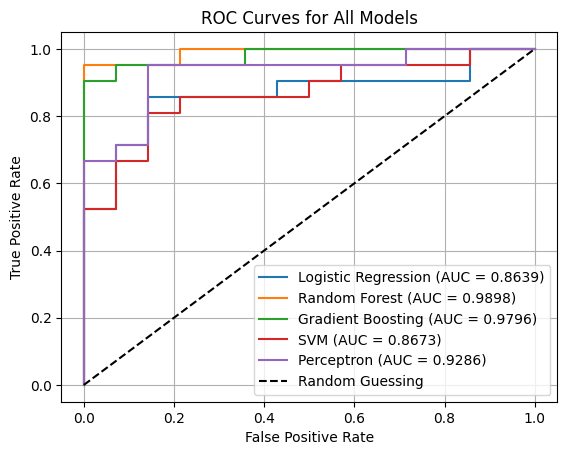


Final Model Performance Summary:


,Model,train_accuracy,Accuracy,Sensitivity,Specificity,AUC
0,Logistic Regression,0.870490,0.800000,0.714286,0.928571,0.863946
1,Random Forest,0.877274,0.914286,0.857143,1.000000,0.989796
2,Gradient Boosting,0.812365,0.914286,0.904762,0.928571,0.979592
3,SVM,0.510792,0.428571,0.047619,1.000000,0.867347
4,Perceptron,0.855843,0.828571,0.809524,0.857143,0.928571


In [ ]:
# Use Logistic Regression as a feature selector
from sklearn.feature_selection import SelectFromModel

# Define Logistic Regression model for feature selection
lr = LogisticRegression(random_state=8)


# Define feature selector using SelectFromModel with Logistic Regression
selector = SelectFromModel(lr, threshold="mean",max_features=20) # Or use another threshold like "median"

# Feature selection
selected_features = select_features(X_train, y_train, selector, standardize=True)

# Hyperparameter tuning
# Combine Results
train_results, train_metrics_df = tune_hyperparameters(X_train, y_train, model_parameters, selected_features)
test_metrics_df = evaluate_test_set(X_train, X_test, y_test, train_results)

# Merge Tables
final_summary_df = pd.merge(train_metrics_df, test_metrics_df, on='Model')
print("\nFinal Model Performance Summary:")
final_summary_df

## RFE (Recursive Feature Elimination)

For RFE(), the get_support() method already returns the boolean array indicating which features are selected, so there’s no need to handle coefficient extraction as for models like Ridge or Lasso

In [ ]:
from sklearn.feature_selection import RFE

def select_features_rfe(X_train, y_train, feature_selector, standardize=False):
    """
    Perform feature selection using RFE (Recursive Feature Elimination) and score the features.

    Args:
        X_train (pd.DataFrame): Training feature set.
        y_train (pd.Series): Training target.
        feature_selector (RFE): Feature selection method (RFE).
        standardize (bool): Whether to standardize the features before selection.

    Returns:
        list: Selected feature names.
        dict: Feature rankings and scores.
    """
    # Optionally standardize the features
    if standardize:
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    # Apply feature selection
    feature_selector.fit(X_train, y_train)
    selected_features = feature_selector.get_support()
    feature_names = X_train.columns[selected_features]

    # Ranking the features based on RFE's ranking_ attribute
    feature_ranking = dict(zip(X_train.columns, feature_selector.ranking_))

    # Display the selected features
    print("\nSelected Features by RFE:")
    for name in feature_names:
        print(f"{name}: Rank {feature_ranking[name]}")

    # Return selected features and their rankings
    return feature_names

### Lasso


Selected Features by RFE:
pressure_var24
total_time24
air_time25
disp_index25
gmrt_in_air25
gmrt_on_paper25
max_x_extension25
max_y_extension25
mean_acc_in_air25
mean_acc_on_paper25
mean_gmrt25
mean_jerk_in_air25
mean_jerk_on_paper25
mean_speed_in_air25
mean_speed_on_paper25
num_of_pendown25
paper_time25
pressure_mean25
pressure_var25
total_time25

Tuning Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Logistic Regression Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best Logistic Regression AUC Score: 0.815
Best Logistic Regression Accuracy: 0.756

Tuning Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest AUC Score: 0.798
Best Random Forest Accuracy: 0.734

Tuning Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Gradient Boosting AUC Score: 0.761
Best Gradient Boosting Accuracy: 0.683

Tuning SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best SVM Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM AUC Score: 0.811
Best SVM Accuracy: 0.756

Tuning Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(


Best Perceptron Parameters: {'eta0': 0.1, 'penalty': 'l2'}
Best Perceptron AUC Score: 0.754
Best Perceptron Accuracy: 0.698

Evaluation Results on Test Set:

Evaluating Logistic Regression...
Accuracy: 0.886
Sensitivity: 0.810
Specificity: 1.000
AUC: 0.9592

Evaluating Random Forest...
Accuracy: 0.829
Sensitivity: 0.762
Specificity: 0.929
AUC: 0.9320

Evaluating Gradient Boosting...
Accuracy: 0.857
Sensitivity: 0.857
Specificity: 0.857
AUC: 0.9116

Evaluating SVM...
Accuracy: 0.857
Sensitivity: 0.810
Specificity: 0.929
AUC: 0.9524

Evaluating Perceptron...
Accuracy: 0.686
Sensitivity: 0.524
Specificity: 0.929
AUC: 0.8095


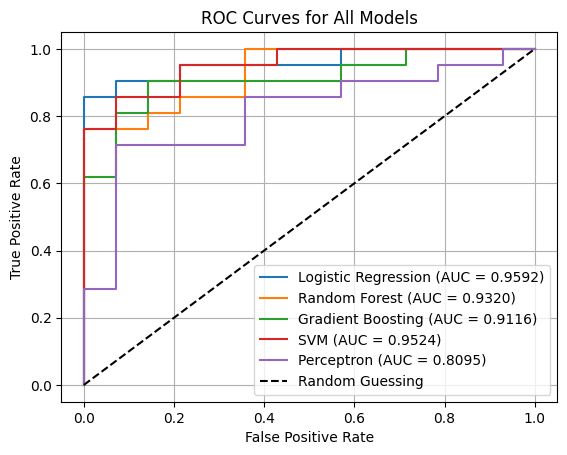


Final Model Performance Summary:


,Model,train_accuracy,Accuracy,Sensitivity,Specificity,AUC
0,Logistic Regression,0.755628,0.885714,0.809524,1.000000,0.959184
1,Random Forest,0.734043,0.828571,0.761905,0.928571,0.931973
2,Gradient Boosting,0.683472,0.857143,0.857143,0.857143,0.911565
3,SVM,0.756244,0.857143,0.809524,0.928571,0.952381
4,Perceptron,0.698119,0.685714,0.523810,0.928571,0.809524


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
# Define feature selector
selector = RFE(Lasso(random_state=8), n_features_to_select=20)

# Feature selection
selected_features = select_features_rfe(X_train, y_train, selector, standardize=True)

# Hyperparameter tuning
# Combine Results
train_results, train_metrics_df = tune_hyperparameters(X_train, y_train, model_parameters, selected_features)
test_metrics_df = evaluate_test_set(X_train, X_test, y_test, train_results)

# Merge Tables
final_summary_df = pd.merge(train_metrics_df, test_metrics_df, on='Model')
print("\nFinal Model Performance Summary:")
final_summary_df

### Ridge

In [ ]:
from sklearn.linear_model import Ridge

# Define feature selector
selector = RFE(Ridge(random_state=8), n_features_to_select=25)

# Feature selection
selected_features = select_features_rfe(X_train, y_train, selector, standardize=True)

# Hyperparameter tuning
# Combine Results
train_results, train_metrics_df = tune_hyperparameters(X_train, y_train, model_parameters, selected_features)
test_metrics_df = evaluate_test_set(X_train, X_test, y_test, train_results)

# Merge Tables
final_summary_df = pd.merge(train_metrics_df, test_metrics_df, on='Model')
print("\nFinal Model Performance Summary:")
final_summary_df


Selected Features by RFE:
mean_acc_in_air3: Rank 1
mean_jerk_in_air4: Rank 1
mean_speed_in_air4: Rank 1
num_of_pendown5: Rank 1
pressure_mean5: Rank 1
gmrt_on_paper6: Rank 1
disp_index7: Rank 1
gmrt_on_paper8: Rank 1
mean_acc_on_paper9: Rank 1
max_x_extension10: Rank 1
mean_acc_in_air10: Rank 1
mean_acc_in_air13: Rank 1
paper_time13: Rank 1
pressure_mean14: Rank 1
air_time15: Rank 1
pressure_var16: Rank 1
total_time17: Rank 1
num_of_pendown19: Rank 1
mean_jerk_on_paper21: Rank 1
paper_time21: Rank 1
mean_jerk_in_air22: Rank 1
mean_speed_in_air23: Rank 1
paper_time23: Rank 1
mean_jerk_on_paper24: Rank 1
air_time25: Rank 1


## Bootstrapping

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Stability Selection with Lasso
n_bootstraps = 50
selected_features = np.zeros(X_train_scaled.shape[1])

for i in range(n_bootstraps):
    # Bootstrap sampling
    bootstrap_idx = np.random.choice(range(X_train_scaled.shape[0]), size=X_train_scaled.shape[0], replace=True)
    X_bootstrap, y_bootstrap = X_train_scaled[bootstrap_idx], y_train.iloc[bootstrap_idx]

    # Lasso model (with standardized data)
    lasso = Lasso(alpha=0.01, random_state=i)
    lasso.fit(X_bootstrap, y_bootstrap)
    selected_features += (lasso.coef_ != 0)

# Retain features selected in at least 60% of bootstraps
threshold = 0.55 * n_bootstraps
robust_features = np.where(selected_features >= threshold)[0]
X_stable = X_train.iloc[:, robust_features]

print(f"Selected {len(robust_features)} robust features via Stability Selection.")

# 2. Refine with Feature Importance (Random Forest)
rf = RandomForestClassifier(n_estimators=100, random_state=8)
rf.fit(X_stable, y_train)
importances = rf.feature_importances_
top_features = np.argsort(importances)[-50:]  # Retain top 50 features
X_important = X_stable.iloc[:, top_features]

print(f"Refined to {len(top_features)} features with Random Forest importance.")

# 3. RFE for Optimal Subset
rfe = RFE(estimator=RandomForestClassifier(n_estimators=50, random_state=8), n_features_to_select=20)
rfe.fit(X_important, y_train)
X_final = X_important.iloc[:, rfe.support_]

print(f"Final feature set contains {X_final.shape[1]} features.")

# Use only the selected features for training and testing
X_train_final = X_train.loc[:, X_final.columns]
X_test_final = X_test.loc[:, X_final.columns]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.928e-03, tolerance: 3.473e-03
  model = cd_fast.enet_coordinate_descent(


Selected 20 robust features via Stability Selection.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Refined to 20 features with Random Forest importance.
Final feature set contains 20 features.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
# Get importance scores for the final features
final_importance_scores = importances[top_features][rfe.support_]  # Use RFE support to filter top features
ranked_features = sorted(zip(X_final.columns, final_importance_scores), key=lambda x: x[1], reverse=True)

# Print ranked features
print(f"Ranked final features ({len(ranked_features)}):")
for rank, (feature, score) in enumerate(ranked_features, start=1):
    print(f"{rank}. {feature} - Importance: {score:.4f}")

Ranked final features (20):
1. total_time17 - Importance: 0.1565
2. paper_time20 - Importance: 0.1079
3. air_time22 - Importance: 0.0867
4. num_of_pendown19 - Importance: 0.0848
5. mean_speed_on_paper8 - Importance: 0.0675
6. pressure_var19 - Importance: 0.0670
7. mean_speed_in_air23 - Importance: 0.0485
8. max_x_extension25 - Importance: 0.0429
9. mean_acc_on_paper9 - Importance: 0.0380
10. max_x_extension21 - Importance: 0.0360
11. gmrt_on_paper2 - Importance: 0.0359
12. mean_speed_in_air19 - Importance: 0.0348
13. max_x_extension22 - Importance: 0.0304
14. max_y_extension25 - Importance: 0.0294
15. air_time19 - Importance: 0.0286
16. mean_jerk_in_air22 - Importance: 0.0271
17. mean_jerk_on_paper24 - Importance: 0.0263
18. mean_jerk_in_air2 - Importance: 0.0191
19. mean_acc_on_paper16 - Importance: 0.0166
20. pressure_var6 - Importance: 0.0162



Tuning Logistic Regression...
Best Logistic Regression Parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Best Logistic Regression AUC Score: 0.977
Best Logistic Regression Accuracy: 0.907

Tuning Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest AUC Score: 0.979
Best Random Forest Accuracy: 0.921

Tuning Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Gradient Boosting Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50}
Best Gradient Boosting AUC Score: 0.945
Best Gradient Boosting Accuracy: 0.864

Tuning SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best SVM Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM AUC Score: 0.976
Best SVM Accuracy: 0.885

Tuning Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(


Best Perceptron Parameters: {'eta0': 0.0001, 'penalty': 'l1'}
Best Perceptron AUC Score: 0.962
Best Perceptron Accuracy: 0.885

Evaluation Results on Test Set:

Evaluating Logistic Regression...
Accuracy: 0.829
Sensitivity: 0.762
Specificity: 0.929
AUC: 0.8980

Evaluating Random Forest...
Accuracy: 0.914
Sensitivity: 0.905
Specificity: 0.929
AUC: 0.9898

Evaluating Gradient Boosting...
Accuracy: 0.857
Sensitivity: 0.810
Specificity: 0.929
AUC: 0.9796

Evaluating SVM...
Accuracy: 0.857
Sensitivity: 0.810
Specificity: 0.929
AUC: 0.9116

Evaluating Perceptron...
Accuracy: 0.400
Sensitivity: 0.000
Specificity: 1.000
AUC: 0.8980


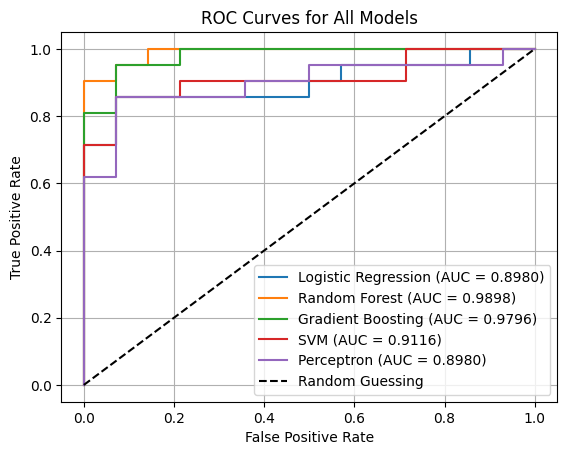


Final Model Performance Summary:


,Model,train_accuracy,Accuracy,Sensitivity,Specificity,AUC
0,Logistic Regression,0.906568,0.828571,0.761905,0.928571,0.897959
1,Random Forest,0.921061,0.914286,0.904762,0.928571,0.989796
2,Gradient Boosting,0.863552,0.857143,0.809524,0.928571,0.979592
3,SVM,0.884829,0.857143,0.809524,0.928571,0.911565
4,Perceptron,0.884675,0.400000,0.000000,1.000000,0.897959


In [ ]:
#-------------(0.6 IN BOOTSTRAPPING) --------------------------

# Hyperparameter tuning
# Combine Results
train_results, train_metrics_df = tune_hyperparameters(X_train, y_train, model_parameters, X_final.columns)
test_metrics_df = evaluate_test_set(X_train, X_test, y_test, train_results)

# Merge Tables
final_summary_df = pd.merge(train_metrics_df, test_metrics_df, on='Model')
print("\nFinal Model Performance Summary:")
final_summary_df


Tuning Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Logistic Regression Parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Logistic Regression AUC Score: 0.972
Best Logistic Regression Accuracy: 0.892

Tuning Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest AUC Score: 0.976
Best Random Forest Accuracy: 0.921

Tuning Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Gradient Boosting Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50}
Best Gradient Boosting AUC Score: 0.942
Best Gradient Boosting Accuracy: 0.878

Tuning SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best SVM Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM AUC Score: 0.973
Best SVM Accuracy: 0.899

Tuning Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Best Perceptron Parameters: {'eta0': 0.0001, 'penalty': 'l1'}
Best Perceptron AUC Score: 0.977
Best Perceptron Accuracy: 0.907

Evaluation Results on Test Set:

Evaluating Logistic Regression...
Accuracy: 0.800
Sensitivity: 0.714
Specificity: 0.929
AUC: 0.8878

Evaluating Random Forest...
Accuracy: 0.943
Sensitivity: 0.905
Specificity: 1.000
AUC: 1.0000

Evaluating Gradient Boosting...
Accuracy: 0.943
Sensitivity: 0.905
Specificity: 1.000
AUC: 0.9932

Evaluating SVM...
Accuracy: 0.857
Sensitivity: 0.762
Specificity: 1.000
AUC: 0.8980

Evaluating Perceptron...
Accuracy: 0.400
Sensitivity: 0.000
Specificity: 1.000
AUC: 0.8980


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(


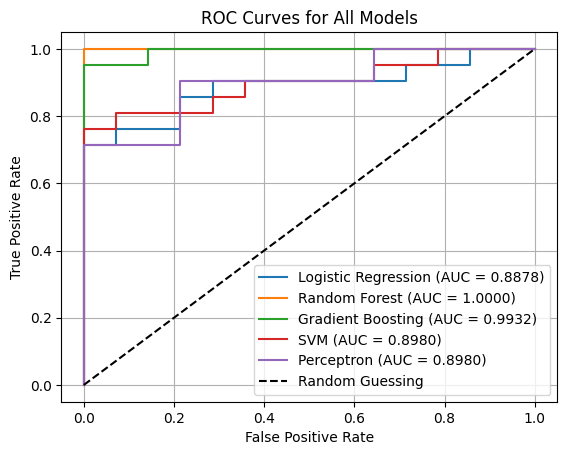


Final Model Performance Summary:


,Model,train_accuracy,Accuracy,Sensitivity,Specificity,AUC
0,Logistic Regression,0.892075,0.800000,0.714286,0.928571,0.887755
1,Random Forest,0.921061,0.942857,0.904762,1.000000,1.000000
2,Gradient Boosting,0.878045,0.942857,0.904762,1.000000,0.993197
3,SVM,0.899322,0.857143,0.761905,1.000000,0.897959
4,Perceptron,0.906568,0.400000,0.000000,1.000000,0.897959


In [ ]:
#-------------(0.55 IN BOOTSTRAPPING) --------------------------

# Hyperparameter tuning
# Combine Results
train_results, train_metrics_df = tune_hyperparameters(X_train, y_train, model_parameters, X_final.columns)
test_metrics_df = evaluate_test_set(X_train, X_test, y_test, train_results)

# Merge Tables
final_summary_df = pd.merge(train_metrics_df, test_metrics_df, on='Model')
print("\nFinal Model Performance Summary:")
final_summary_df

# Feature names selected: Comparison

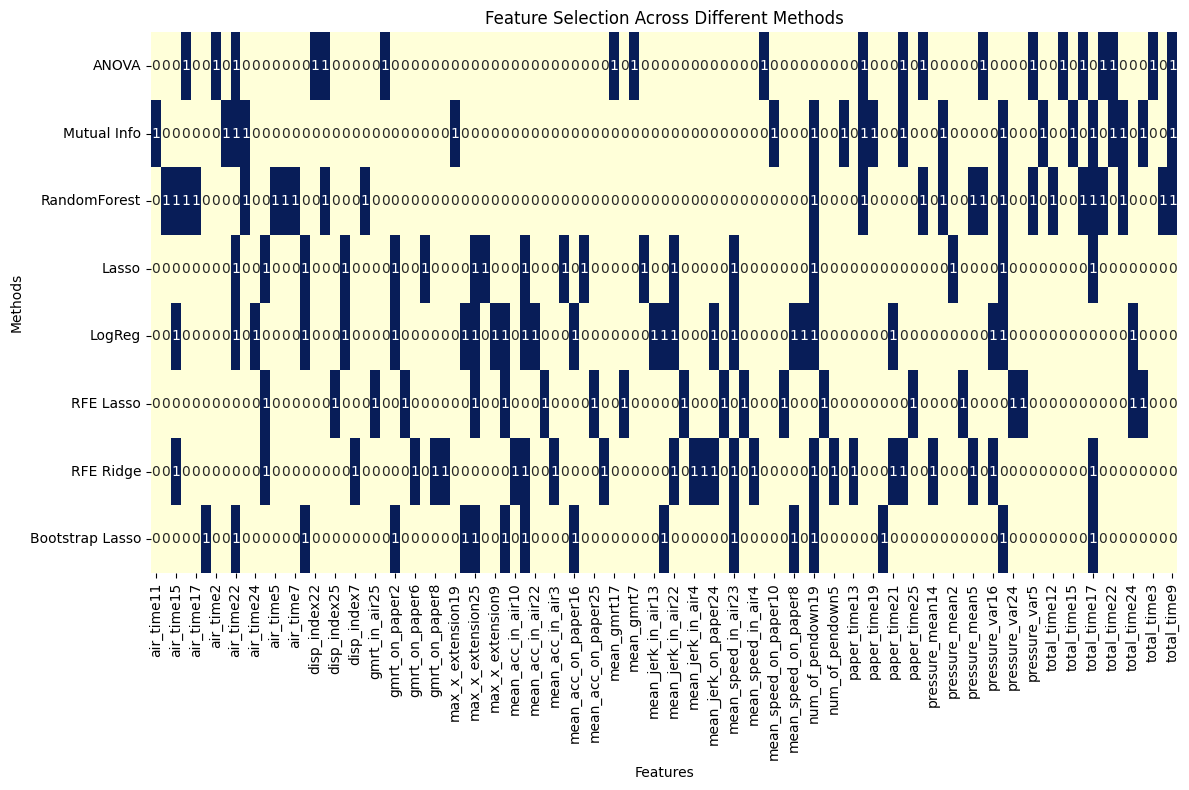

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define feature selection methods and their selected features
methods = {
    'ANOVA': ['disp_index23', 'total_time2', 'gmrt_in_air7', 'total_time3', 'air_time16', 'paper_time17',
              'total_time13', 'paper_time9', 'paper_time23', 'mean_speed_in_air7', 'air_time2', 'total_time16',
              'disp_index22', 'mean_gmrt7', 'mean_gmrt17', 'air_time22', 'total_time22', 'pressure_var5',
              'total_time9', 'pressure_mean8'],

    'Mutual Info': ['total_time10', 'total_time17', 'num_of_pendown19', 'total_time25', 'total_time15',
                    'paper_time11', 'total_time9', 'air_time23', 'pressure_mean19', 'paper_time23', 'air_time22',
                    'max_x_extension19', 'total_time22', 'total_time23', 'air_time20', 'air_time11', 'pressure_var19',
                    'paper_time19', 'paper_time17', 'mean_speed_on_paper10'],

    'RandomForest': ['total_time23', 'air_time17', 'air_time5', 'total_time17', 'pressure_var19', 'air_time16',
                     'paper_time17', 'total_time9', 'air_time15', 'air_time23', 'total_time2', 'pressure_mean5',
                     'total_time16', 'total_time6', 'pressure_var5', 'num_of_pendown19', 'disp_index23', 'gmrt_in_air17',
                     'pressure_mean8', 'air_time6', 'total_time12', 'air_time7', 'air_time13', 'pressure_mean19', 'paper_time9'],

    'Lasso': ['air_time22', 'num_of_pendown19', 'pressure_mean2', 'pressure_var19', 'mean_jerk_in_air22', 'gmrt_on_paper6'
                            'mean_speed_on_paper8', 'max_x_extension4', 'gmrt_on_paper2', 'mean_jerk_in_air10', 'mean_acc_on_paper16'
                            'mean_jerk_in_air2', 'mean_acc_in_air13', 'mean_acc_on_paper12', 'disp_index4', 'mean_speed_in_air23',
                            'air_time25', 'max_x_extension25', 'disp_index21', 'total_time17'],

    'LogReg': ['num_of_pendown19', 'pressure_var19', 'disp_index21', 'max_x_extension21', 'mean_jerk_in_air22',
               'gmrt_on_paper2', 'num_of_pendown14', 'max_x_extension25', 'disp_index4', 'mean_acc_in_air22',
               'max_y_extension25', 'mean_acc_on_paper16', 'mean_jerk_on_paper24', 'air_time24', 'air_time22',
               'mean_acc_in_air13', 'mean_speed_on_paper8', 'max_x_extension9', 'air_time15', 'mean_jerk_in_air13',
               'mean_speed_in_air23', 'pressure_var16', 'mean_jerk_in_air2', 'total_time24', 'paper_time21'],

    'RFE Lasso': ['pressure_var24', 'total_time24', 'air_time25', 'disp_index25', 'gmrt_in_air25', 'gmrt_on_paper25',
                  'max_x_extension25', 'max_y_extension25', 'mean_acc_in_air25', 'mean_acc_on_paper25', 'mean_gmrt25',
                  'mean_jerk_in_air25', 'mean_jerk_on_paper25', 'mean_speed_in_air25', 'mean_speed_on_paper25',
                  'num_of_pendown25', 'paper_time25', 'pressure_mean25', 'pressure_var25', 'total_time25'],

    'RFE Ridge': ['mean_acc_in_air3', 'mean_jerk_in_air4', 'mean_speed_in_air4', 'num_of_pendown5', 'pressure_mean5',
                  'gmrt_on_paper6', 'disp_index7', 'gmrt_on_paper8', 'mean_acc_on_paper9', 'max_x_extension10',
                  'mean_acc_in_air10', 'mean_acc_in_air13', 'paper_time13', 'pressure_mean14', 'air_time15',
                  'pressure_var16', 'total_time17', 'num_of_pendown19', 'mean_jerk_on_paper21', 'paper_time21',
                  'mean_jerk_in_air22', 'mean_speed_in_air23', 'paper_time23', 'mean_jerk_on_paper24', 'air_time25'],

    'Bootstrap Lasso': ['total_time17', 'air_time22', 'paper_time20', 'pressure_var19', 'mean_speed_on_paper8',
                        'num_of_pendown19', 'mean_jerk_in_air2', 'max_x_extension25', 'mean_speed_in_air23',
                        'max_x_extension21', 'gmrt_on_paper2', 'mean_acc_on_paper16', 'max_y_extension25',
                        'disp_index21', 'air_time19', 'mean_acc_in_air13']
}

# Create a list of all unique features
all_features = sorted(set([feature for features in methods.values() for feature in features]))

# Create a DataFrame with binary indicators for each feature and method
df = pd.DataFrame(0, index=all_features, columns=methods.keys())

# Populate the DataFrame with 1s where a feature is selected by a method
for method, features in methods.items():
    df.loc[features, method] = 1

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.T, cmap="YlGnBu", annot=True, fmt='d', cbar=False)
plt.title("Feature Selection Across Different Methods")
plt.xlabel("Features")
plt.ylabel("Methods")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Count the number of selections for each feature across all methods
feature_counts = df.sum(axis=1)

# Sort the features by the count in descending order
sorted_feature_counts = feature_counts.sort_values(ascending=False)

# Display the sorted list of features with their selection counts
print("Features ordered by frequency of selection:")
for feature, count in sorted_feature_counts.items():
    print(f"{feature}: {count} selections")


Features ordered by frequency of selection:
num_of_pendown19: 6 selections
pressure_var19: 5 selections
air_time22: 5 selections
total_time17: 5 selections
mean_acc_in_air13: 4 selections
mean_speed_in_air23: 4 selections
max_x_extension25: 4 selections
total_time9: 3 selections
mean_jerk_in_air22: 3 selections
gmrt_on_paper2: 3 selections
paper_time17: 3 selections
paper_time23: 3 selections
disp_index21: 3 selections
max_y_extension25: 3 selections
air_time25: 3 selections
air_time15: 3 selections
pressure_var16: 2 selections
total_time23: 2 selections
mean_acc_on_paper16: 2 selections
total_time25: 2 selections
mean_jerk_on_paper24: 2 selections
total_time24: 2 selections
mean_speed_on_paper8: 2 selections
total_time22: 2 selections
pressure_var5: 2 selections
total_time2: 2 selections
paper_time21: 2 selections
total_time16: 2 selections
paper_time9: 2 selections
pressure_mean19: 2 selections
pressure_mean5: 2 selections
pressure_mean8: 2 selections
mean_jerk_in_air2: 2 selections


# Base ground: Whole features

## Funtions definition

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import numpy as np

def w_tune_hyperparameters(X_train, y_train, model_params):
    """
    Tune the hyperparameters for each model using GridSearchCV on all features.

    Args:
        X_train (pd.DataFrame): Training feature set.
        y_train (pd.Series): Training target.
        model_params (dict): Dictionary with model names, estimators, and param grids.

    Returns:
        dict: Best models with hyperparameters.
    """
    results = {}

    # Define models that require standardization
    models_that_need_scaling = ['Logistic Regression', 'SVM', 'Perceptron']

    # Train and tune models
    for model_name, (model, param_grid) in model_params.items():
        print(f"\nTuning {model_name}...")

        # Standardize only if the model is in the list of models that need scaling
        if model_name in models_that_need_scaling:
            print(f"Standardizing data for {model_name}...")
            scaler = StandardScaler()
            X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        else:
            X_train_scaled = X_train  # No scaling for tree-based models

        grid_search = GridSearchCV(estimator=clone(model), param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

        # Train with all features (no feature selection applied here)
        grid_search.fit(X_train_scaled, y_train)

        print(f"Best {model_name} Parameters: {grid_search.best_params_}")
        print(f"Best {model_name} AUC Score: {grid_search.best_score_:.4f}")
        results[model_name] = {
            'best_model': grid_search.best_estimator_,
            'features': X_train.columns.tolist()  # Store all features used
        }

    return results



In [ ]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def w_evaluate_test_set(X_train, X_test, y_test, best_models):
    """
    Evaluate models on the test set, applying standardization for models that require it.

    Args:
        X_train (pd.DataFrame): Training feature set.
        X_test (pd.DataFrame): Test feature set.
        y_test (pd.Series): Test target.
        best_models (dict): Trained models with their hyperparameters.
    """
    print("\nEvaluation Results on Test Set:")
    metrics = []

    # Standardize X_train and X_test only for models that require it
    scaler = StandardScaler()

    for model_name, model_info in best_models.items():
        print(f"\nEvaluating {model_name}...")

        model = model_info['best_model']

        # Apply standardization if the model is sensitive to scaling (e.g., Logistic Regression, SVM)
        if model_name in ['Logistic Regression', 'SVM', 'Perceptron']:  # Update this list if needed
            # Standardize both X_train and X_test
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_test_selected = X_test_scaled  # Use the standardized version of X_test
        else:
            # For tree-based models, no scaling is needed
            X_train_scaled = X_train
            X_test_scaled = X_test
            X_test_selected = X_test_scaled  # No feature selection, using full features

        # Get predictions and probabilities/scores
        if hasattr(model, 'predict_proba'):
            y_probs = model.predict_proba(X_test_selected)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_probs = model.decision_function(X_test_selected)
        else:
            y_probs = model.predict(X_test_selected)

        y_preds = (y_probs >= 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_preds)
        sensitivity = recall_score(y_test, y_preds)
        tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
        specificity = tn / (tn + fp)
        auc = roc_auc_score(y_test, y_probs)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Sensitivity: {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"AUC: {auc:.4f}")

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')

        metrics.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'AUC': auc
        })

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    return pd.DataFrame(metrics)


## Evaluation


Evaluation Results on Test Set:

Evaluating Logistic Regression...
Accuracy: 0.8857
Sensitivity: 0.8571
Specificity: 0.9286
AUC: 0.9320

Evaluating Random Forest...
Accuracy: 0.9143
Sensitivity: 0.9048
Specificity: 0.9286
AUC: 0.9830

Evaluating Gradient Boosting...
Accuracy: 0.9143

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(



Sensitivity: 0.9524
Specificity: 0.8571
AUC: 0.9932

Evaluating SVM...
Accuracy: 0.8286
Sensitivity: 0.8095
Specificity: 0.8571
AUC: 0.8912

Evaluating Perceptron...
Accuracy: 0.8571
Sensitivity: 0.8095
Specificity: 0.9286
AUC: 0.9150


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(


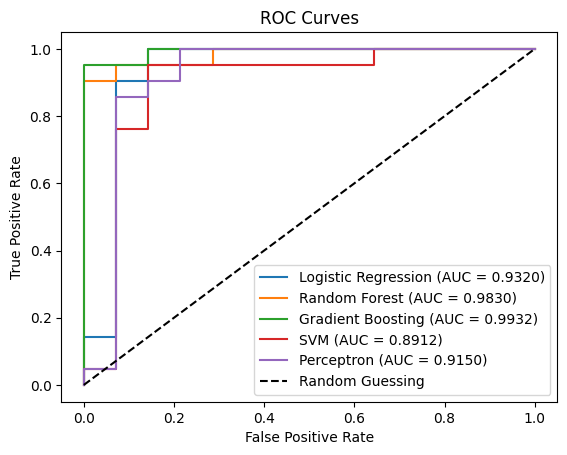

                 Model  Accuracy  Sensitivity  Specificity       AUC
0  Logistic Regression  0.885714     0.857143     0.928571  0.931973
1        Random Forest  0.914286     0.904762     0.928571  0.982993
2    Gradient Boosting  0.914286     0.952381     0.857143  0.993197
3                  SVM  0.828571     0.809524     0.857143  0.891156
4           Perceptron  0.857143     0.809524     0.928571  0.914966


In [ ]:
# Hyperparameter tuning
best_models = w_tune_hyperparameters(X_train, y_train, model_parameters)

# Evaluate on test set
metrics_df = w_evaluate_test_set(X_train,X_test, y_test, best_models)
print(metrics_df)


---

## **Discussion**  
This project aimed to address the high dimensionality of the DARWIN dataset by employing feature selection methods and evaluating their impact on classification performance. However, the analysis revealed no clear indicator of the best handwriting feature for distinguishing AD patients from healthy individuals.  

When comparing the results of **eight different feature selection methods**, there was no overlap in the features consistently selected by the methods, suggesting variability in their selection criteria. This highlights the challenge of identifying universally representative handwriting features for AD diagnosis.  

Despite this variability, **Random Forest** emerged as the best-performing classifier, achieving the highest accuracy during training. Among the feature selection techniques, **Mutual Information** and **Bootstrapping** stood out, as the features selected by these methods resulted in the best classification performance when used for training.

### Key Findings
- **Random Forest** performed best across multiple feature selection methods, achieving >90% accuracy.
- The **"Copy the details of a postal code"** task was the most predictive, appearing in 6/8 feature selection methods.
- **Copy and memory tasks** were more effective than graphic tasks for AD classification.

### Limitations
- Unsupervised models (e.g., K-Means, GMM) performed poorly, with clustering results close to random.
- No consensus on the optimal feature set across different selection methods.

---

## **Conclusion**  

### Summary of Results
- **Best Model**: Random Forest with bootstrapping feature selection (AUC = 1.0).
- **Most Predictive Task**: "Copy the details of a postal code."
- **Unsupervised Learning**: Not effective for AD diagnosis in its current form.

### Future Work
1. Refine feature selection methods to identify a consistent set of predictive features.
2. Explore advanced unsupervised learning techniques for unlabelled data.
3. Expand the dataset to improve model generalizability.

### Visual Summary
| Model               | Accuracy | Sensitivity | Specificity | AUC   |
|---------------------|----------|-------------|-------------|-------|
| Random Forest       | 94.28%   | 90.47%      | 100%        | 1.0   |
| Logistic Regression | 88.57%   | 80.95%      | 100%        | 0.959 |


These findings highlight the need for further research into robust feature selection strategies that can provide consistent results across different methods and models. Future work could explore ensemble feature selection or hybrid approaches to address the observed variability.  